# Vegetation phenology in the Ruko Conservancy

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).


## Description

This notebook will produce annual, smoothed, **one-dimensional (zonal mean across a region)** time-series of a remote sensing vegetation indice, such as NDVI or EVI.  In addition, basic phenology statistics are calculated, exported to disk as csv files, and annotated on a plot.

A number of steps are required to produce the desired outputs:

1. Load satellite data for a region specified by an vector file (shapefile or geojson)
2. Buffer the cloud masking layer to better mask clouds in the data (Sentinel-2 cloud mask is quite poor)
3. Further prepare the data for analysis by removing bad values (infs), masking surafce water, and removing outliers in the vegetation index.
4. Calculate a zonal mean across the study region (collapse the x and y dimension by taking the mean across all pixels for each time-step).
5. Interpolate and smooth the time-series to ensure a consistent dataset with all gaps and noise removed.
6. Calculate phenology statistics, report the results, save the results to disk, and generate an annotated plot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile
import deafrica_tools.temporal as ts
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster(spare_mem='2Gb')

/usr/local/lib/python3.8/dist-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34119 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34913 Dashboard: /user/victoria@kartoza.com/proxy/34119/status,Cluster Workers: 1 Cores: 4 Memory: 29.14 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Landsat-8: `'ls8_cl2'`
* `shapefile`: The path to the vector file delineating the analysis region. Can be a shapefile or a geojson
* `time_range`: The year range to analyse (e.g. `('2017-01-01', '2019-12-30')`).
* `min_gooddata`: the fraction of good data (not cloudy) a scene must have before it is returned as a dataset 
* `resolution`: The pixel resolution, in metres, of the returned dataset
* `dask_chunks`: The size, in number of pixel, for the dask chunks on each dimension.

In [3]:
veg_proxy = 'NDVI'

product = 's2_l2a'

shapefile='data/Ruko_conservancy.geojson'

time_range = ('2017-01-01', '2020-12-31')

resolution = (-20,20)

dask_chunks = {'x':500, 'y':500}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Vegetation_phenology')

## View the region of interest
The next cell will display the selected area on an web map.

In [5]:
#First open the shapefile using geopandas
gdf = gpd.read_file(shapefile)

In [6]:
map_shapefile(gdf, attribute='ConsrvName')

Label(value='')

Map(center=[0.6480841040610879, 36.12258148195494], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

The cell directly below will create a query object using the first geometry in the shapefile, along with the parameters we defined in the Analysis Parameters section above.

In [7]:
# Create a reusable query
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

query = {
    "geopolygon": geom,
    'time': time_range,
    'measurements': ['red','nir','green','swir_1'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}


Load available data from S2. The cloud masking data for Sentinel-2 is less than perfect, and missed cloud in the data greatly impacts vegetation calculations. load_ard supports morphological operations on the cloud-masking bands to improve the masking of poor quality data.

In [8]:
filters=[("opening", 3), ("dilation", 2)]

ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    dask_chunks=dask_chunks,
    mask_filters=filters,
    **query,
)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 267 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 267, y: 1194, x: 607)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2020-12-27T08:...
  * y            (y) float64 9.461e+04 9.459e+04 ... 7.077e+04 7.075e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spat

## Mask the satellite data with shape

In [9]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

#convert to float 32 to conserve memory
ds=ds.astype(np.float32)

## Calculate vegetation and water indices

In [10]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=[veg_proxy, 'MNDWI'], satellite_mission='s2', drop=True)

Dropping bands ['red', 'nir', 'green', 'swir_1']


## Prepare data for analysis

Remove any NaN or infinite values, mask water, remove any outliers in the vegetation index.  We then reduce the data to a 1D timeseries by calculating the mean across the x and y dimensions.  

We will also 'compute' the data on the dask cluster to speed up calculations later on. This step will take 5-10mins to run since we are now computing everything that came before.

In [11]:
# remove any infinite values
ds = ds.where(~np.isinf(ds))
# mask water
ds = ds.where(ds.MNDWI < 0)

#remove outliers (if NDVI greater than 1.0, set to NaN, if less than 0 set to NaN) 
ds[veg_proxy] = xr.where(ds[veg_proxy]>1.0, np.nan, ds[veg_proxy])
ds[veg_proxy] = xr.where(ds[veg_proxy]<0, np.nan, ds[veg_proxy])

# create 1D line plots
veg = ds[veg_proxy].mean(['x', 'y']).compute()

## Smooth and interpolate time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will smooth and interpolate the data to ensure we working with a consistent time-series.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps

In [12]:
resample_period='2W'
window=4

veg_smooth=veg.resample(time=resample_period, label='left', loffset='1W').median().rolling(time=window, min_periods=1).mean()

## Plot the entire time-series

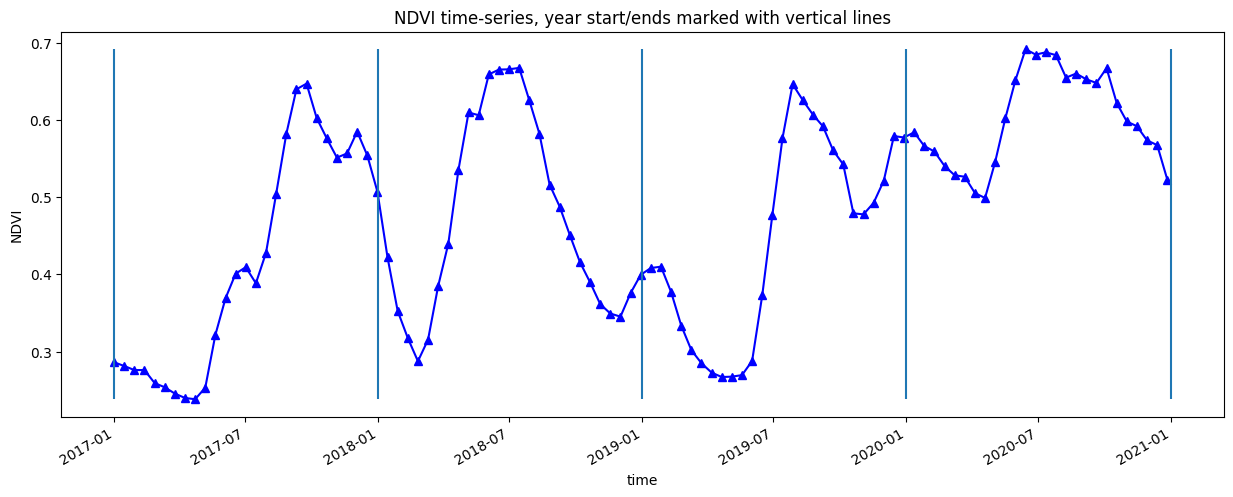

In [13]:
veg_smooth.plot.line('b-^', figsize=(15,5))
_max=veg_smooth.max()
_min=veg_smooth.min()
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy);

## Compute basic phenology statistics

Below we specify the statistics to calculate, and the method we'll use for determining the statistics. 

The statistics acronyms are as follows:
* `SOS` - Day of year of Start of Season
* `vSOS` - value at Start of Season
* `POS` - Day of year of Peak of Season
* `vPOS` - value at Peak of Season
* `EOS` - Day of year of End of Season
* `vEOS` - value at End of Season
* `Trough` - minimum value across the dataset timeframe
* `LOS` - Length of Season, measured in days
* `AOS` - Amplitude of Season, the difference between `vPOS` and `Trough`
* `ROG` - Rate of Greening, rate of change from start to peak of season
* `ROS` - Rate of Senescing, rae of change from peak to end of season

Options are 'first' & 'median' for `method_sos`, and 'last' & 'median' for `method_eos`.

    method_sos : str 
            If 'first' then vSOS is estimated as the first positive 
            slope on the greening side of the curve. If 'median',
            then vSOS is estimated as the median value of the postive
            slopes on the greening side of the curve.

    method_eos : str
            If 'last' then vEOS is estimated as the last negative slope
            on the senescing side of the curve. If 'median', then vEOS is
            estimated as the 'median' value of the negative slopes on the
            senescing side of the curve.

In [14]:
basic_pheno_stats = ['SOS','vSOS','POS','vPOS','EOS','vEOS','Trough','LOS','AOS','ROG','ROS']
method_sos = 'first'
method_eos = 'last'

In [15]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    print(year)
    #select year
    da = dict(years)[year]
    
    #calculate stats
    with HiddenPrints():
        stats=ts.xr_phenology(
                da,
                method_sos=method_sos,
                method_eos=method_eos,
                stats=basic_pheno_stats,
                    )
    #add results to dict    
    pheno_results[str(year)] = stats

2017
2018
2019
2020


### Print the phenology statistics for each year, and write the results to disk as a .csv

In [16]:
for key,value in pheno_results.items():
    print('Year: ' +key)
    for b in value.data_vars:
        print("   "+b+": ", round(float(value[b].values),4))

    pheno_results[key].drop('spatial_ref').assign_coords({'index':[key]}).to_dataframe().to_csv('results/'+key+'_phenology.csv')

Year: 2017
   SOS:  113.0
   vSOS:  0.2382
   POS:  267.0
   vPOS:  0.6469
   EOS:  365.0
   vEOS:  0.507
   Trough:  0.2382
   LOS:  252.0
   AOS:  0.4088
   ROG:  0.0027
   ROS:  -0.0014
Year: 2018
   SOS:  70.0
   vSOS:  0.3153
   POS:  196.0
   vPOS:  0.6674
   EOS:  336.0
   vEOS:  0.3451
   Trough:  0.2874
   LOS:  266.0
   AOS:  0.3799
   ROG:  0.0028
   ROS:  -0.0023
Year: 2019
   SOS:  125.0
   vSOS:  0.2674
   POS:  209.0
   vPOS:  0.6462
   EOS:  307.0
   vEOS:  0.4776
   Trough:  0.2669
   LOS:  182.0
   AOS:  0.3793
   ROG:  0.0045
   ROS:  -0.0017
Year: 2020
   SOS:  110.0
   vSOS:  0.4988
   POS:  166.0
   vPOS:  0.6915
   EOS:  362.0
   vEOS:  0.5226
   Trough:  0.4988
   LOS:  252.0
   AOS:  0.1927
   ROG:  0.0034
   ROS:  -0.0009


## Annotate phenology on a plot

This image will be saved to disk in the `results/` folder

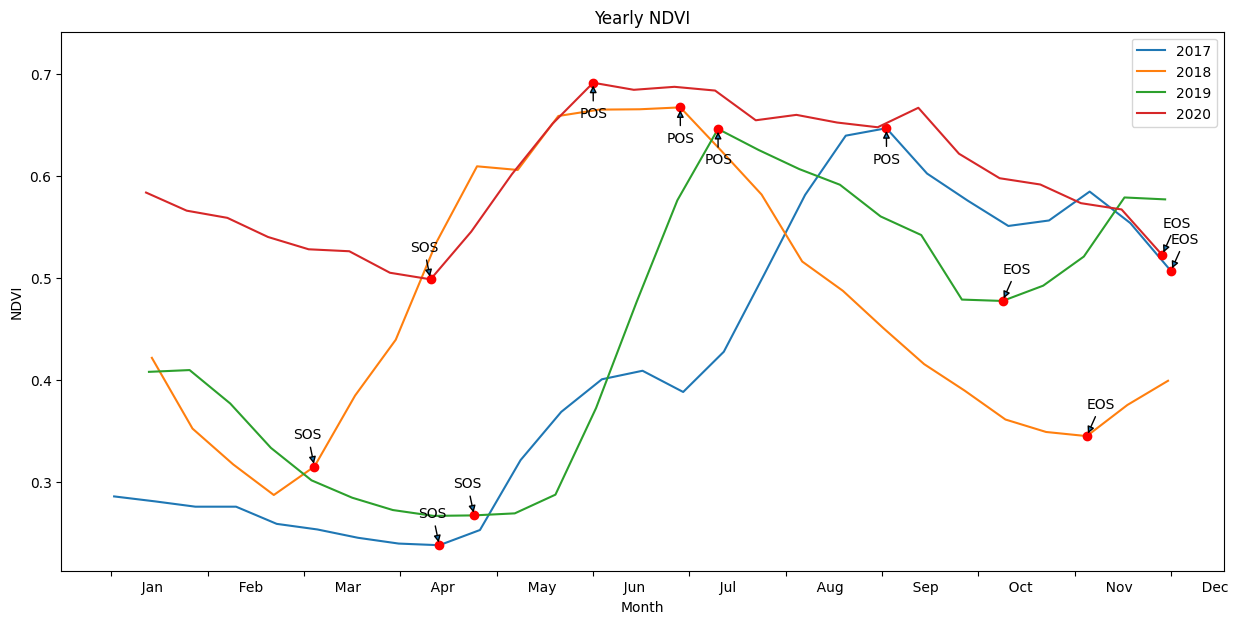

In [17]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
for year, y in zip(years, years_int):
    #grab tall the values we need for plotting
    eos = pheno_results[str(y)].EOS.values
    sos = pheno_results[str(y)].SOS.values
    pos = pheno_results[str(y)].POS.values

    veos = pheno_results[str(y)].vEOS.values
    vsos = pheno_results[str(y)].vSOS.values
    vpos = pheno_results[str(y)].vPOS.values
    
    #create plot
    #the groupby and mean below doesn't actually do anything, except allow
    #the plots to be on the same x-axis. i.e. veg-data isn't modified, just time units
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0])

    #add start of season
    ax.plot(sos, vsos, 'or')
    ax.annotate('SOS',
                xy=(sos, vsos),
                xytext=(-15, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add end of season
    ax.plot(eos, veos, 'or')
    ax.annotate('EOS',
                xy=(eos, veos),
                xytext=(0, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add peak of season
    ax.plot(pos, vpos, 'or')
    ax.annotate('POS',
                xy=(pos, vpos),
                xytext=(-10, -25),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

ax.legend()
plt.ylim(_min-0.025,_max.values+0.05)
month_abbr=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
new_m=[]
for m in month_abbr:
    new_m.append('       %s'%m) #Add spaces before the month name
plt.xticks(np.linspace(0,365,12), new_m, horizontalalignment='left')
plt.xlabel('Month')
plt.ylabel(veg_proxy)
plt.title('Yearly '+ veg_proxy)
plt.savefig('results/yearly_phenology_plot.png');

The basic phenology statistics are summarised in a more readable format below. We can compare the statistics at a high level. Further analysis should be conducted using the .csv exports in the `/results` folder.

In [18]:
print(xr.concat([pheno_results[str(year)] for year in years_int],
                dim=pd.Index(years_int, name='time')).to_dataframe().drop(columns=['spatial_ref']).T.to_string())

time          2017        2018        2019        2020
SOS     113.000000   70.000000  125.000000  110.000000
vSOS      0.238188    0.315340    0.267428    0.498817
POS     267.000000  196.000000  209.000000  166.000000
vPOS      0.646945    0.667361    0.646223    0.691529
EOS     365.000000  336.000000  307.000000  362.000000
vEOS      0.507020    0.345142    0.477616    0.522630
Trough    0.238188    0.287414    0.266936    0.498817
LOS     252.000000  266.000000  182.000000  252.000000
AOS       0.408757    0.379947    0.379287    0.192712
ROG       0.002654    0.002794    0.004509    0.003441
ROS      -0.001428   -0.002302   -0.001720   -0.000862


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-01-30'